In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.append('/Users/joewandy/work/git/vimms')
sys.path.append('/Users/joewa/work/git/vimms')
sys.path.append('/home/joewandy/vimms')

In [3]:
from os.path import exists
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

from vimms.Common import load_obj, save_obj, create_if_not_exist
from mass_spec_utils.library_matching.spec_libraries import GNPSLibrary

In [4]:
from vimms.scripts.DDA_vs_DIA import compare_spectra, spectral_distribution, pairwise_spectral_distribution, \
    spec_records_to_library, plot_matching_thresholds, \
    plot_score_distributions, plot_pairwise_similarity, venn_diagram

In [5]:
min_intensity = 25000

In [6]:
clms_home = os.path.abspath('real_data_analysis_%d' % min_intensity)
base_folder = os.path.join(clms_home, 'fragmentation_files')
output_folder = os.path.abspath('DDA_vs_DIA_real_similiarity_gnps_%d' % min_intensity)
create_if_not_exist(output_folder)

In [7]:
matching_thresholds = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
# matching_thresholds = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

matching_method = 'cosine'
matching_ms1_tol = 1
matching_ms2_tol = 0.05
matching_min_match_peaks = 3

gnps_file = os.path.join(clms_home, 'msp', 'GNPS-NIST14-MATCHES.mgf')

methods = [
    'topN',
    'SWATH',
    'AIF'
]

In [8]:
pickle_file = os.path.join(output_folder, 'gnps_library.p')
if not exists(pickle_file):
    chem_library = GNPSLibrary([gnps_file])
    pos_spectra = [spec for spec in chem_library.sorted_record_list if spec.metadata['IONMODE'].lower() == 'positive']
    pos_library = spec_records_to_library(pos_spectra)    
    save_obj(pos_library, pickle_file)
    
chem_library = load_obj(pickle_file)
print(len(chem_library.sorted_record_list))

5274


In [9]:
sns.set_context('poster')

# 1. Plot hit proportions across various thresholds

In [10]:
pickle_file = os.path.join(output_folder, 'hit_proportions_df.p')
if not exists(pickle_file):
    hit_prop_df = compare_spectra(chem_library, base_folder, methods, matching_thresholds, 
                                  matching_method, matching_ms1_tol, 
                                  matching_ms2_tol, matching_min_match_peaks)
    hit_prop_df.to_pickle(pickle_file)

In [11]:
hit_prop_df = pd.read_pickle(os.path.join(output_folder, 'hit_proportions_df.p'))
hit_prop_df.head()

,method,matching_threshold,no_annotated_compounds,no_annotated_peaks,prop_annotated_compounds,prop_annotated_peaks,annotated_peaks
0,topN,0.0,3867,2392,0.733220,0.392775,"{peak_439.291470, Unknown, 439.29147, fullscan..."
1,topN,0.1,3160,1910,0.599166,0.313629,"{peak_439.291470, Unknown, 439.29147, fullscan..."
2,topN,0.2,2408,1470,0.456579,0.241379,"{peak_439.291470, Unknown, 439.29147, fullscan..."
3,topN,0.3,1755,1057,0.332765,0.173563,"{peak_277.139400, Unknown, 277.1394, fullscan_..."
4,topN,0.4,1265,724,0.239856,0.118883,"{peak_277.139400, Unknown, 277.1394, fullscan_..."


{'AIF': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'SWATH': (1.0, 0.4980392156862745, 0.054901960784313725),
 'topN': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)}

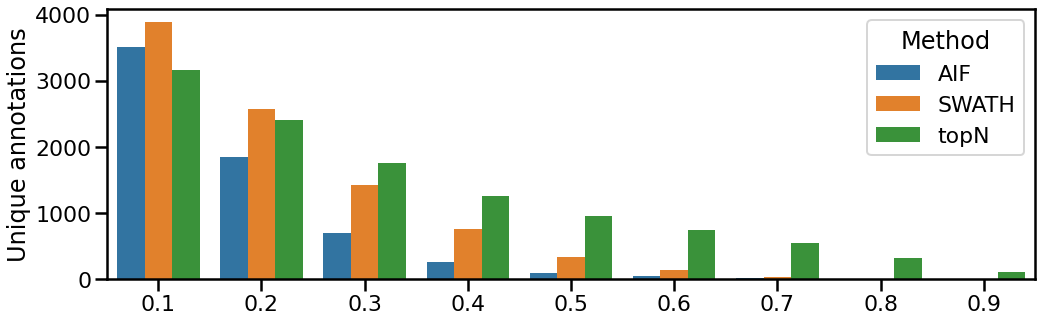

In [12]:
out_file = os.path.join(output_folder, 'hit_proportions.png')
palette = plot_matching_thresholds(hit_prop_df, out_file=out_file)
palette

# 2. Venn diagrams

In [13]:
methods

['topN', 'SWATH', 'AIF']

327 51 10 295 21 4


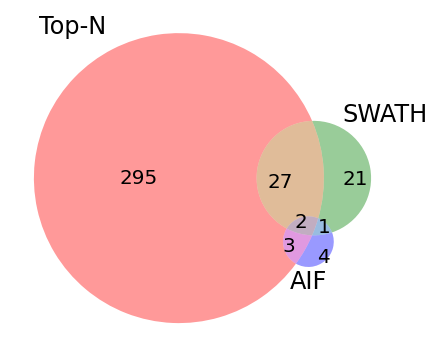

In [33]:
threshold = 0.6
out_file = os.path.join(output_folder, 'venn_diagram.png')
venn_diagram(hit_prop_df, methods, threshold, out_file=out_file)

# 3. Plot Distribution of spectral similarity scores

In [15]:
matching_threshold = 0.0

In [16]:
pickle_file = os.path.join(output_folder, 'score_df.p')
if not exists(pickle_file):
    score_df = spectral_distribution(chem_library, base_folder, methods, matching_threshold, 
                                     matching_method, matching_ms1_tol, 
                                     matching_ms2_tol, matching_min_match_peaks, keep_all=False)  
    score_df.to_pickle(pickle_file)    

In [17]:
score_df = pd.read_pickle(os.path.join(output_folder, 'score_df.p'))
score_df = score_df[score_df['score'] > 0.0]
score_df['score_percent'] = score_df['score'] * 100

In [18]:
score_df.method.unique()

array(['topN', 'SWATH', 'AIF'], dtype=object)

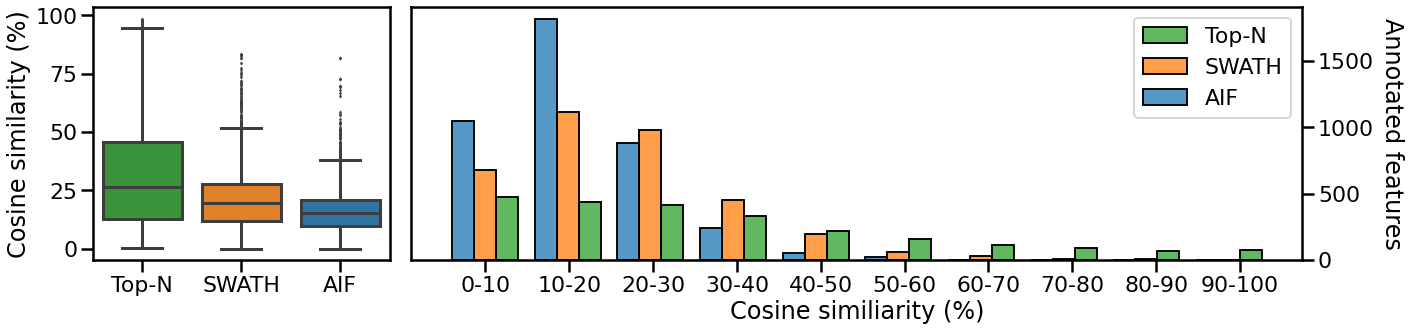

In [19]:
out_file = os.path.join(output_folder, 'score_distributions.png')
_ = plot_score_distributions(score_df, palette=palette, bins=10, out_file=out_file)

In [20]:
score_df.groupby(['method'])['score_percent'].median()

method
AIF      15.175559
SWATH    19.502342
topN     26.507863
Name: score_percent, dtype: float64

# 4. Plot Pairwise Similarity of Spectra

In [21]:
matching_threshold = 0.0

In [22]:
pickle_file = os.path.join(output_folder, 'pairwise_score_df.p')
if not exists(pickle_file):
    pairwise_score_df = pairwise_spectral_distribution(chem_library, base_folder, methods, matching_threshold,
                                                       matching_method, matching_ms1_tol, 
                                                       matching_ms2_tol, matching_min_match_peaks)
    pairwise_score_df.to_pickle(pickle_file)    

In [23]:
pairwise_score_df = pd.read_pickle(os.path.join(output_folder, 'pairwise_score_df.p'))
pairwise_score_df.shape

(334684, 3)

In [24]:
pairwise_score_df

,method,spectrum_id,score
0,ground_truth,CCMSLIB00003136158,0.000000
1,ground_truth,CCMSLIB00003136907,0.091661
2,ground_truth,CCMSLIB00003135860,0.000000
3,ground_truth,CCMSLIB00003136907,0.000000
4,ground_truth,CCMSLIB00003135860,0.091661
...,...,...,...
334679,AIF,peak_847.290220,0.466710
334680,AIF,peak_847.290220,0.466710
334681,AIF,peak_846.306150,0.466710
334682,AIF,peak_901.477230,0.537749


[Text(0, 0, 'ground_truth'),
 Text(1, 0, 'topN'),
 Text(2, 0, 'SWATH'),
 Text(3, 0, 'AIF')]

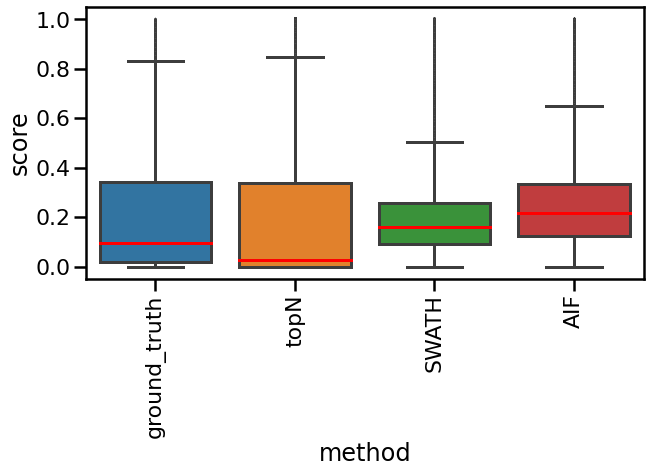

In [25]:
plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=pairwise_score_df, x='method', y='score', showfliers=True, 
                 medianprops={'color': 'red', 'lw': 3}, flierprops = dict(markerfacecolor = '0.50', markersize = 2))
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

{'AIF': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'SWATH': (1.0, 0.4980392156862745, 0.054901960784313725),
 'topN': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'ground_truth': (0.17254901960784313,
  0.6274509803921569,
  0.17254901960784313),
 'ref_spec_gnps': 'white',
 'ref_spec_intensity': 'white'}

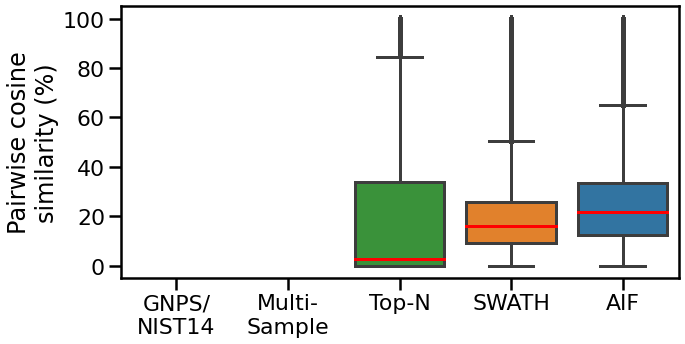

In [26]:
plot_pairwise_similarity(pairwise_score_df, palette=palette)

### Combined plot

In [27]:
gnps_output_folder = os.path.abspath('DDA_vs_DIA_real_similiarity_gnps_%d' % min_intensity)
intensity_output_folder = os.path.abspath('DDA_vs_DIA_real_similiarity_intensity_non_overlap_%d' % min_intensity)

In [28]:
pairwise_score_gnps = pd.read_pickle(os.path.join(gnps_output_folder, 'pairwise_score_df.p'))
pairwise_score_gnps.shape

(334684, 3)

In [29]:
pairwise_score_intensity = pd.read_pickle(os.path.join(intensity_output_folder, 'pairwise_score_df.p'))
pairwise_score_intensity.shape

(279095, 3)

In [30]:
df1 = pairwise_score_gnps[pairwise_score_gnps['method'] == 'ground_truth'].replace('ground_truth', 'ref_spec_gnps')
df2 = pairwise_score_intensity.replace('ground_truth', 'ref_spec_intensity')
combined_df = pd.concat([df1, df2])
combined_df

,method,spectrum_id,score
0,ref_spec_gnps,CCMSLIB00003136158,0.000000
1,ref_spec_gnps,CCMSLIB00003136907,0.091661
2,ref_spec_gnps,CCMSLIB00003135860,0.000000
3,ref_spec_gnps,CCMSLIB00003136907,0.000000
4,ref_spec_gnps,CCMSLIB00003135860,0.091661
...,...,...,...
279090,AIF,peak_847.290220,0.466710
279091,AIF,peak_847.290220,0.466710
279092,AIF,peak_846.306150,0.466710
279093,AIF,peak_901.477230,0.537749


{'AIF': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'SWATH': (1.0, 0.4980392156862745, 0.054901960784313725),
 'topN': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'ground_truth': (0.17254901960784313,
  0.6274509803921569,
  0.17254901960784313),
 'ref_spec_gnps': 'white',
 'ref_spec_intensity': 'white'}

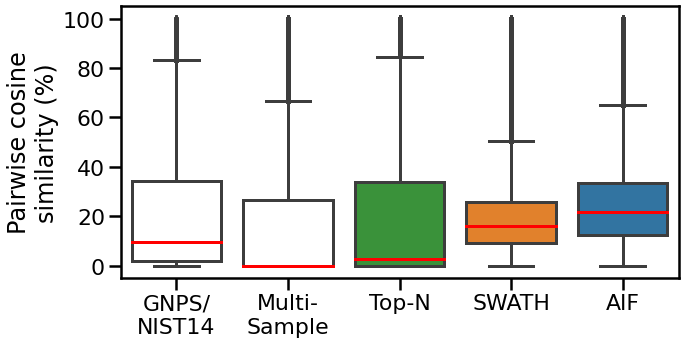

In [31]:
out_file = os.path.join(output_folder, 'pairwise_similarity.png')
plot_pairwise_similarity(combined_df, palette=palette, out_file=out_file)

In [32]:
combined_df.groupby(['method'])['score'].median()

method
AIF                   0.217851
SWATH                 0.159224
ref_spec_gnps         0.094690
ref_spec_intensity    0.000000
topN                  0.026392
Name: score, dtype: float64